In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using Catalyst, DifferentialEquations, Plots, DataFrames

  Activating project at `~/Code/intro_julia_project`


In [ ]:
# rate functions
function active_rtcr(rt, kr, L, c, rtcr)
    alpha = rt / kr
    fa = (1 + alpha)^6 / (L * ((1 + c * alpha)^6) + (1 + alpha)^6)
    return fa * rtcr
end

function tscr_ab(Vmax_init, atp, Km_init, rt, kr, L, c, rtcr, k_diss, ω_ab, θtscr)
    Voc = Vmax_init * atp / (Km_init + atp)  
    sig_o = active_rtcr(rt, kr, L, c, rtcr) * Voc / k_diss 
    return sig_o * ω_ab * atp / (θtscr + atp) 
end

tscr_r(ω_r, atp, θtscr) = ω_r * atp / (θtscr + atp)

function tlr(g_max, atp, θtlr, kc, rh, rm_x, nx)
    tlr_el = g_max*atp/(θtlr+atp)
    return (1 / nx) * kc * rh * rm_x * tlr_el
end

Vrep(rtcb, rt, krep, km_b) = rtcb * rt * krep / (rt + km_b) 
Vtag(rtca, rd, ktag, km_a) = rtca * rd * ktag / (rd + km_a) 


Vtag (generic function with 1 method)

In [ ]:
# model definition
rtc_model = @reaction_network begin

    # transcription
    tscr_ab(Vmax_init, atp, Km_init, rt, kr, L, c, rtcr, k_diss, ω_ab, θtscr),  ∅ => (rm_a, rm_b)
    tscr_r(ω_r, atp, θtscr),                                                    ∅ => rm_r

    # translation
    tlr(g_max, atp, θtlr, kc, rh, rm_a, na),                                    ∅ => rtca  # rm_a + rh --> rtca
    tlr(g_max, atp, θtlr, kc, rh, rm_b, nb),                                    ∅ => rtcb  # rm_b + rh --> rtcb
    tlr(g_max, atp, θtlr, kc, rh, rm_r, nr),                                    ∅ => rtcr  # rm_r + rh --> rtcr

    # tagging and repair
    Vtag(rtca, rd, ktag, km_a),                                                 rd => rt   # rd + rtca --> rt
    Vrep(rtcb, rt, krep, km_b),                                                 rt => rh   # rt + rtcb --> rh

    # mass action reactions
    # influx and damage
    kin,                                                                        ∅ --> rh
    kdam,                                                                       rh --> rd

    # degradation and dilution
    kdeg,                                                                       rd --> ∅
    d,                                                                          (rm_a, rm_b, rm_r) --> ∅
    lam,                                                                        (rm_a, rm_b, rm_r, rtca, rtcb, rtcr, rh, rd, rt) --> ∅

end;

In [ ]:
params = Dict(
    :L => 50., 
    :c => 0.01, 
    :kr => 0.125, 
    :Vmax_init => 39.51, 
    :Km_init => 250, 
    :θtscr => 160.01, 
    :θtlr => 255.73, 
    :na => 338, 
    :nb => 408, 
    :nr => 532*6, 
    :d => 0.2, 
    :krep => 15.67, 
    :ktag => 9780,
    :atp => 3000, 
    :km_a => 20, 
    :km_b => 16, 
    :g_max => 1260, 
    :kdeg => 1, 
    :kin => 0.2554265863569768,
    :ω_ab => 5e-5, 
    :ω_r => 1e-6, 
    :kdam => 0.0, 
    :lam => 0.014, 
    :kc => 0.6, 
    :k_diss => 0.006
)

u0 = Dict(
    :rm_a => 0.0,
    :rm_b => 0.0,
    :rm_r => 0.0,
    :rtca => 0.0,
    :rtcb => 0.0,
    :rtcr => 0.0,
    :rh => 11.29,
    :rd => 0.0,
    :rt => 0.0
)

tspan = (0, 1e9)

(0, 1.0e9)

In [32]:
prob = ODEProblem(rtc_model, u0, tspan, params)
sol = solve(prob, Rodas4());

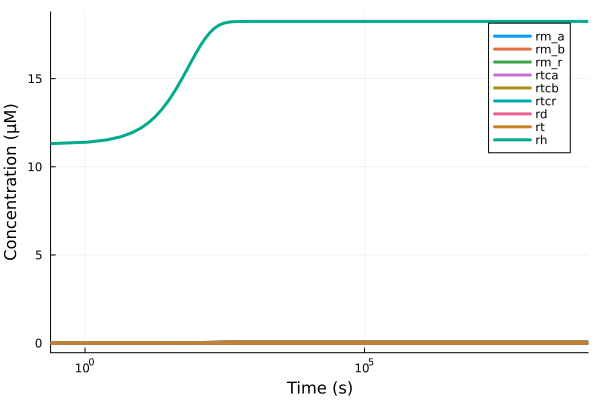

In [33]:
plot(sol[2:end], lw=3, xlabel="Time (s)", ylabel="Concentration (μM)")
plot!(xscale=:log10)

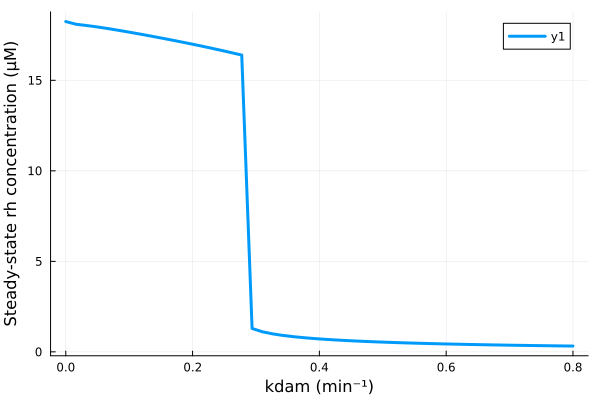

In [37]:
kdam_range = range(0, 0.8, length=50)
new_params = deepcopy(params)
res =[]
for k in kdam_range
    new_params[:kdam] = k
    prob = ODEProblem(rtc_model, u0, (0,1e9), new_params)
    sol = solve(prob, Rodas4())
    df = DataFrame(sol)
    push!(res, df[end, "rh(t)"])
end

plot(kdam_range, res, xlabel="kdam (min⁻¹)", ylabel="Steady-state rh concentration (μM)", lw=3)